# Admin

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from scipy.special import voigt_profile
from scipy.integrate import quad

In [22]:
file = "Temp_Lineshift.xlsx"
column_names = [77, 90, 120, 293]
Td_fixed = 760

In [23]:
#Model functions

def voigt_model_double(x, A1, center1, gamma1, sigma1,
                       A2, delta, gamma2, sigma2, offset):

    return (
        A1 * voigt_profile(x - center1, sigma1, gamma1) +
        A2 * voigt_profile(x - (center1 + delta), sigma2, gamma2) +
        offset
    )
def debye_integrand(x):
    return x**3 / (np.exp(x) - 1)

def debye_integral(T, Td):

    if T <= 0:
        return 0  # avoid divide by zero

    upper = min(Td/T, 50)

    result, _ = quad(
        lambda x: x**3/(np.exp(x)-1),
        0,
        upper
    )

    return result

def ruby_shift_model(T, R0, alpha, Td):
    integral_vals = np.array([debye_integral(t, Td) for t in T])
    return R0 + alpha * (T / Td)**4 * integral_vals

def ruby_shift_model_fixed(T, R0, alpha):
    integral_vals = np.array([debye_integral(t, Td_fixed) for t in T])
    return R0 + alpha * (T / Td_fixed)**4 * integral_vals

#other helper functions

def reduced_chi_squared_calc(model, model_params, xdata, ydata, yerror):
    dof = len(xdata)-len(model_params)
    theoretical = model(xdata,*model_params)
    chi2 = np.sum((theoretical - ydata)**2/(yerror))
    rchi2 = chi2/dof
    return rchi2

def wavelength_extraction(x, start_index):
    A = 0.9958
    B = 9096.6280
    return (start_index - 0.242*x - B) / A

def normalise_spectra(df, cols, wavelengths):

    dx = np.abs(wavelengths[1] - wavelengths[0])
    area_0 = np.sum(df[cols[0]] * dx)

    normalised = []

    for col in cols:
        spec = df[col].to_numpy()
        norm = (spec / np.sum(spec * dx)) * area_0
        normalised.append(norm)

    matrix = np.column_stack(normalised)

    mean_intensity = np.mean(matrix, axis=1)
    error = np.std(matrix, axis=1) / np.sqrt(len(cols))

    return normalised, mean_intensity, error

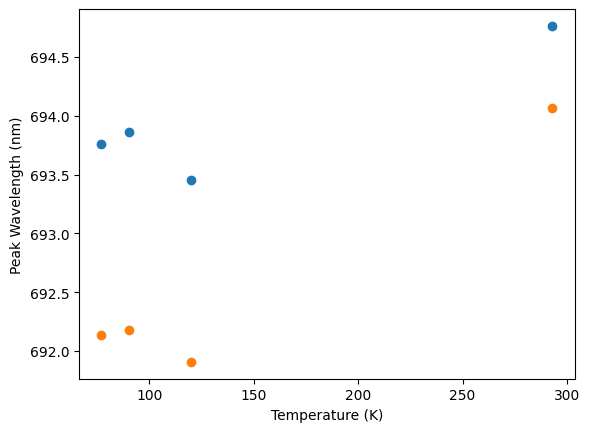

In [30]:
df = pd.read_excel(file)

R1_vals =[]
R2_vals =[]
Temperatures = np.array([77, 90, 120, 293])

for col in column_names:
    R1 = df[col][1]
    R2 = df[col][3]
    R1_vals.append(R1)
    R2_vals.append(R2)

R1_vals = np.array(R1_vals)
R2_vals = np.array(R2_vals)

plt.figure(1)
plt.scatter(Temperatures, R1_vals)
plt.scatter(Temperatures, R2_vals)

plt.xlabel("Temperature (K)")
plt.ylabel("Peak Wavelength (nm)")
plt.show()